In [1]:
import sys
sys.path.insert(1, './..')

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from matplotlib.patches import Rectangle
from math import prod
from tqdm import tqdm
import spark

In [2]:
import sys
sys.path.insert(1, './..')
import spark

In [3]:
spiker_specs = spark.ModuleSpecs(
	name ='spiker', 
	module_cls = spark.nn.interfaces.TopologicalLinearSpiker, 
	inputs = {
		'signal': [
			spark.PortMap(origin='__call__', port='drive'),
		]
	},
	config = spark.nn.interfaces.TopologicalLinearSpikerConfig(
		glue = jnp.array(0), 
		mins = jnp.array(-1),  
		maxs = jnp.array(1), 
		resolution = 128, 
		max_freq = 200.0, 
		tau = 30.0
	)
)

a_ex_specs = spark.ModuleSpecs(
	name ='A_ex', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),
			spark.PortMap(origin='A_ex', port='out_spikes'),
			spark.PortMap(origin='B_in', port='out_spikes'),
		]
	},
	config = spark.nn.neurons.ALIFNeuronConfig(
		units = (256,), 
		inhibitory_rate = 0.0,
		max_delay = 1,
        _s_target_units = (256,),
        _s_async_spikes = True,
        synapses_params__kernel_initializer__scale = 3.0,
		soma_params__threshold_tau = 25.0 * jax.random.uniform(jax.random.key(43), shape=(256,), dtype=jnp.float16)**2,
		soma_params__threshold_delta = 250.0 * jax.random.uniform(jax.random.key(43), shape=(256,), dtype=jnp.float16)**2,
		soma_params__cooldown = 2.0,  
	)
)

a_in_specs = spark.ModuleSpecs(
	name ='A_in', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),
			spark.PortMap(origin='A_ex', port='out_spikes'),
		]
	},
	config = spark.nn.neurons.ALIFNeuronConfig(
		units = (64,), 
		inhibitory_rate = 1.0,
		max_delay = 1,
        _s_target_units = (64,),
        _s_async_spikes = True,
        synapses_params__kernel_initializer__scale = 3.0,
		soma_params__threshold_tau = 1.0,
		soma_params__threshold_delta = 0.0,
		soma_params__cooldown = 2.0,  
	)
)

b_ex_specs = spark.ModuleSpecs(
	name ='B_ex', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),
			spark.PortMap(origin='B_ex', port='out_spikes'),
			spark.PortMap(origin='A_in', port='out_spikes'),
		]
	},
	config = spark.nn.neurons.ALIFNeuronConfig(
		units = (256,), 
		inhibitory_rate = 0.0,
		max_delay = 1,
        _s_target_units = (256,),
        _s_async_spikes = True,
        synapses_params__kernel_initializer__scale = 3.0,
		soma_params__threshold_tau = 25.0 * jax.random.uniform(jax.random.key(43), shape=(256,), dtype=jnp.float16)**2,
		soma_params__threshold_delta = 250.0 * jax.random.uniform(jax.random.key(43), shape=(256,), dtype=jnp.float16)**2,
		soma_params__cooldown = 2.0,  
	)
)

b_in_specs = spark.ModuleSpecs(
	name ='B_in', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),
			spark.PortMap(origin='B_ex', port='out_spikes'),
		]
	},
	config = spark.nn.neurons.ALIFNeuronConfig(
		units = (64,), 
		inhibitory_rate = 1.0,
		max_delay = 1,
        _s_target_units = (64,),
        _s_async_spikes = True,
        synapses_params__kernel_initializer__scale = 3.0,
		soma_params__threshold_tau = 1.0,
		soma_params__threshold_delta = 0.0,
		soma_params__cooldown = 2.0,  
	)
)

integrator = spark.ModuleSpecs(
	name ='integrator', 
	module_cls = spark.nn.interfaces.ExponentialIntegrator, 
	inputs = {
		'spikes': [
			spark.PortMap(origin='A_ex', port='out_spikes'),
			spark.PortMap(origin='B_ex', port='out_spikes'),
		]
	},
	config = spark.nn.interfaces.ExponentialIntegratorConfig(
		num_outputs = 2,
	)
)

AttributeError: 'ZenkeRuleConfig' object has no attribute 'async_spikes'

In [3]:
# Note that the input map can be see as the output of a virtual node (the environment.)
input_map = {
    'drive': spark.InputSpec(
        payload_type=spark.FloatArray, 
        shape=(4,), 
        dtype=jnp.float16,
        is_optional=False,
	)
}
output_map = {
    'integrator': {
        'signal': spark.OutputSpec(
            payload_type=spark.FloatArray, 
            shape=(2,), 
            dtype=jnp.float16
		)
	}
}
modules_map = {
    'spiker': spiker_specs,
    'A_ex': a_ex_specs,
    'A_in': a_in_specs,
	'B_ex': b_ex_specs,
	'B_in': b_in_specs,
	'integrator': integrator,
}

brain_config = spark.nn.BrainConfig(input_map=input_map, output_map=output_map, modules_map=modules_map)

In [4]:
brain = spark.nn.Brain(config=brain_config)

In [5]:
brain(drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)))

E0927 18:23:00.942629   63271 hlo_lexer.cc:443] Failed to parse int literal: 4248521593997812759231801


{'integrator.signal': FloatArray(value=Array([0., 0.], dtype=float16))}

In [6]:
@jax.jit
def run_model(graph, state, x):
	model = spark.merge(graph, state)
	out = model(drive=x)
	_, state = spark.split((model))
	return out, state

@jax.jit
def retrieve_spikes(graph, state,):
	model = spark.merge(graph, state)
	spikes = model.get_spikes_from_cache()
	return spikes

def process_obs(x):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	x = x / np.array([2.4, 2.5, 0.2095, 3.5])
	x = np.clip(x, a_min=-1, a_max=1)
	return x

def compute_real_reward(x, x_prev, r_prev, terminated):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	if terminated:
		return 0
	r = (x_prev[0]**2 - x[0]**2) + (x_prev[2]**2 - x[2]**2)
	r = np.clip(0.5 * r_prev + 2 * r, a_min=-1, a_max=1)
	return r

100%|██████████| 100/100 [00:01<00:00, 84.75it/s]


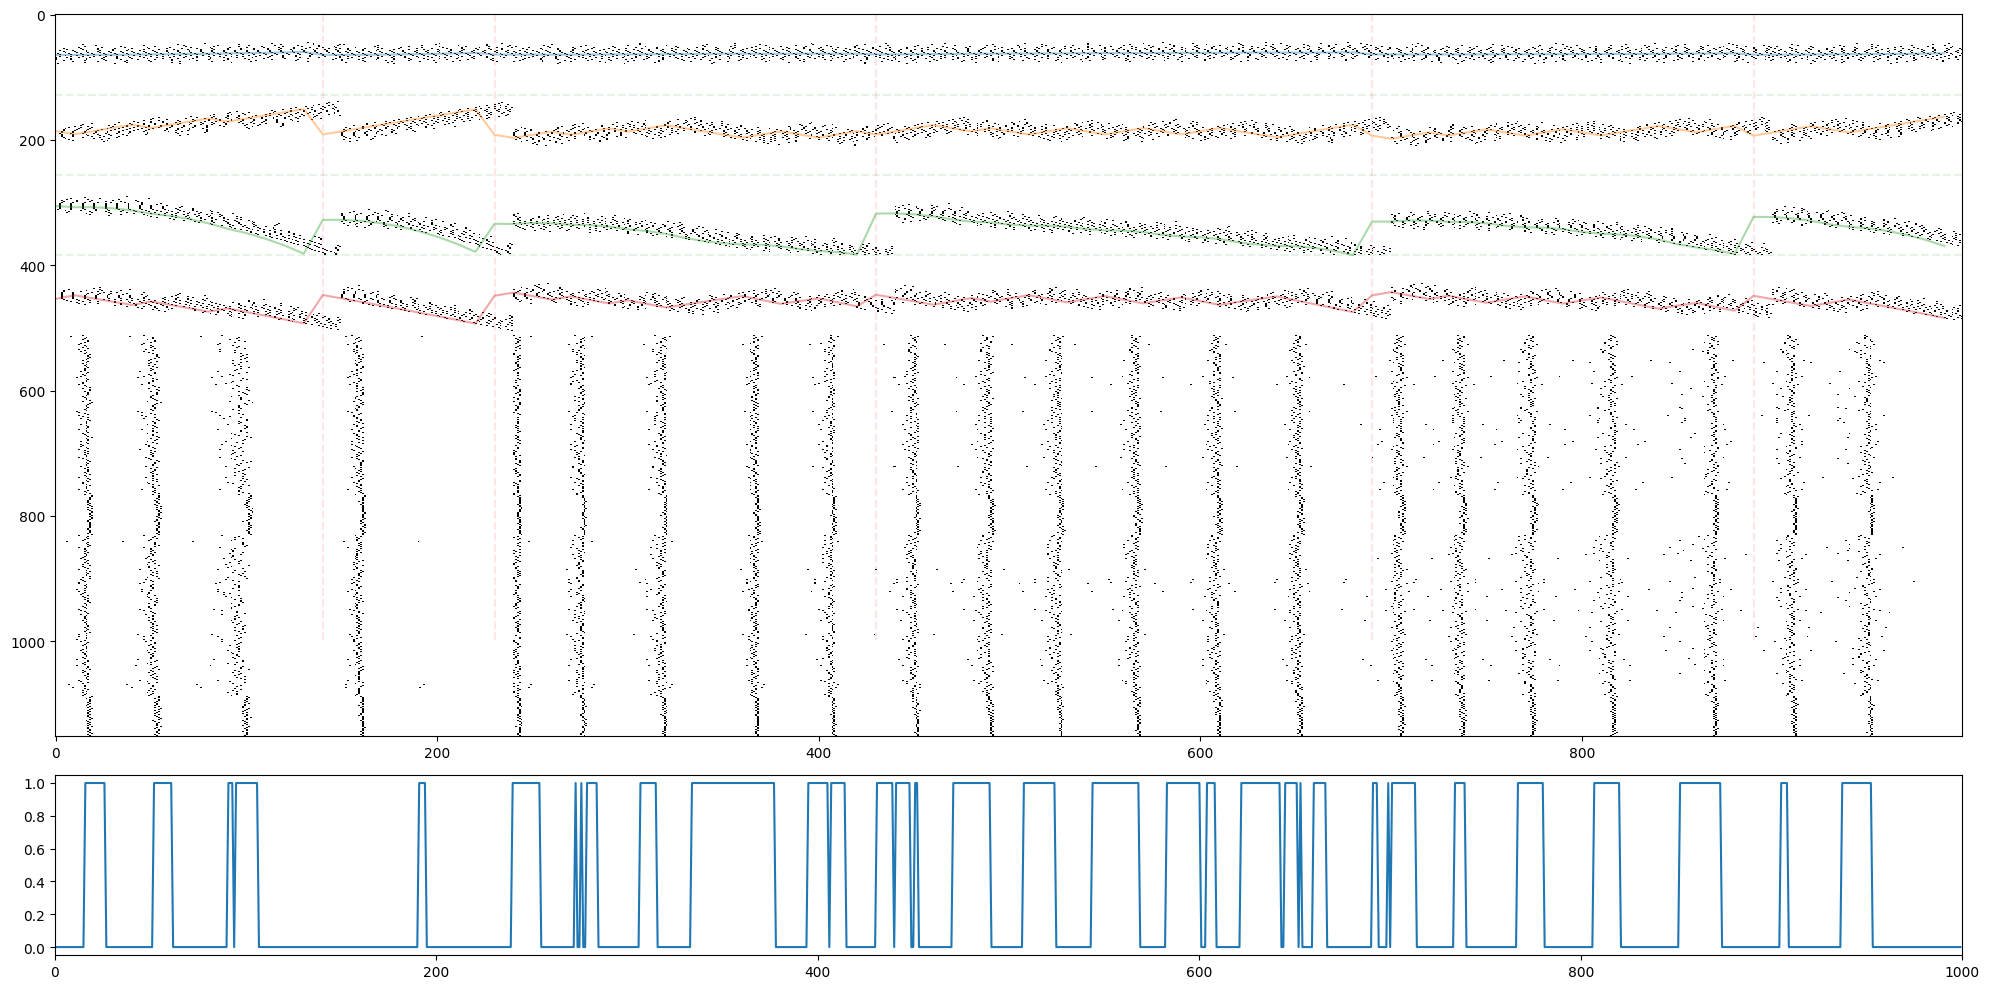

In [17]:
import time
import gymnasium as gym
import ale_py
import numpy as np
gym.register_envs(ale_py)

env_name =  'CartPole-v1'

env = gym.make(env_name)
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

model = spark.nn.Brain(config=brain_config)
model(drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)))
graph, state = spark.split((model))
#starting_kernel = model.neurons.synapses.get_flat_kernel()
brain_steps_per_env_step = 10

if True:
	reward = 0
	reward_array = []
	for i in tqdm(range(10000)):
		prev_obs = next_obs
		# Model logic
		out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		# Environment logic.
		next_action = int(np.argmax(out['integrator.signal'].value))
		next_obs, _, terminated, truncated, info = env.step(next_action)
		if terminated:
			next_obs, _ = env.reset()
			# Flush model
			for i in range(16):
				_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
		next_obs = process_obs(next_obs)
		reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
		reward_array.append(reward)

outs = []
spikes = []
obs = []
breaks = []
break_obs = []
actions = []
reward = 0
next_obs, _ = env.reset(seed=42+1)
next_obs = process_obs(next_obs)
for i in tqdm(range(100)):
	prev_obs = next_obs
	# Model logic
	for _ in range(brain_steps_per_env_step):
		out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		outs.append(out['integrator.signal'].value)
		model_spikes = retrieve_spikes(graph, state)
		spikes.append(
			jnp.concatenate([
				model_spikes['spiker'].value.reshape(-1),
				model_spikes['A_ex'].value.reshape(-1),
				model_spikes['A_in'].value.reshape(-1),
				model_spikes['B_ex'].value.reshape(-1),
				model_spikes['B_in'].value.reshape(-1),
			])
		)
		# Environment logic.
		next_action = int(np.argmax(out['integrator.signal'].value))
		actions.append(next_action)
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		break_obs.append(next_obs)
		next_obs, _ = env.reset()
		breaks.append(brain_steps_per_env_step*i)
		# Flush model
		for i in range(50):
			_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
	obs.append(next_obs)
	
model = spark.merge(graph, state)

spikes = np.abs(np.array(spikes))
fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,len(spikes)-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[0]+64, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[1]+64+128, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[2]+64+256, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(actions)
ax[1].set_xlim(0, len(actions))
plt.tight_layout()
plt.show()
if False:
	plt.imshow(starting_kernel, aspect='auto', interpolation='none')
	plt.colorbar()
	plt.show()
	plt.imshow(final_kernel, aspect='auto', interpolation='none')
	plt.colorbar()
	plt.show()

In [ ]:
%gui qt
import sys
sys.path.insert(1, './..')
import spark

In [ ]:
editor = spark.SparkGraphEditor()
if __name__ == "__main__":
    editor.launch()